In [47]:
pip install osmnx

EPSG:4326


<Axes: >

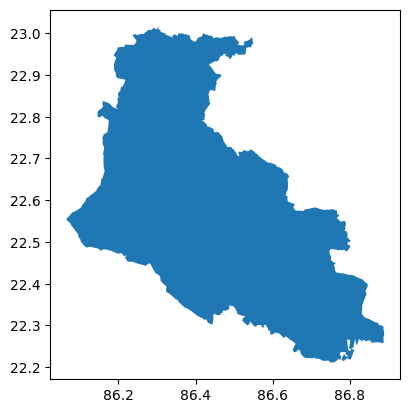

In [50]:
import osmnx as ox
import geopandas as gpd

#Jamshedpur falls under East Singhbhum district
city_name = "East Singhbhum, Jharkhand, India"
gdf = ox.geocode_to_gdf(city_name)

#Save as GeoJSON properly
gdf.to_file("jsr_boundary.geojson", driver="GeoJSON")

#Load again with geopandas
city_boundary = gpd.read_file("jsr_boundary.geojson")

print(city_boundary.crs)
city_boundary.plot()


# GEE Processing

In [62]:
import ee

ee.Authenticate()
ee.Initialize(project="gee-jsr")

#1. Converting GeoJSON to GEE geometry
city_boundary = gpd.read_file('jsr_boundary.geojson')
aoi_geometry = city_boundary.geometry.iloc[0].__geo_interface__
aoi = ee.Geometry.Polygon(aoi_geometry['coordinates'])

#2. Filtering the Landsat Image Collection ---
collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2025-04-01', '2025-06-30') \
    .filter(ee.Filter.lt('CLOUD_COVER', 10))

#3. Median composite
image = collection.median()

## NDVI (Normalized Difference Vegetation Index)

In [63]:
#Selecting Band 5 (SR_B5) from the Landsat 9 satellite image, which is the layer that specifically measures Near-Infrared (NIR) light
nir = image.select('SR_B5')
#Selecting Band 4 (SR_B4), which is the layer that measures visible Red light
red = image.select('SR_B4')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

## Land Surface Temperature (LST)

In [64]:
thermal_band = image.select('ST_B10')
lst = thermal_band.multiply(0.00341802).add(149.0).subtract(273.15).rename('LST')

## Clipping to Area of Interest

In [65]:
final_ndvi = ndvi.clip(aoi)
final_lst = lst.clip(aoi)
print("GEE processing complete! Ready to export or visualize.")

GEE processing complete! Ready to export or visualize.


##

In [52]:
import folium
from geemap import foliumap

#Visualization parameters
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
lst_vis = {'min': 20, 'max': 45, 'palette': ['blue', 'yellow', 'red']}

/tmp/ipython-input-4045693217.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [city_boundary.centroid.y.iloc[0], city_boundary.centroid.x.iloc[0]]


## Centering the map on my AOI i.e. Jamshedpur

In [66]:
#Ensuring the city boundary is in the standard WGS84 (lat/lon) format, which Folium requires.
city_boundary = city_boundary.to_crs(epsg=4326)
#the geographic center (centroid) of Jamshedpur to position the map view.
map_center = [city_boundary.centroid.y.iloc[0], city_boundary.centroid.x.iloc[0]]

m = folium.Map(location=map_center, zoom_start=10)

/tmp/ipython-input-3382394874.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [city_boundary.centroid.y.iloc[0], city_boundary.centroid.x.iloc[0]]


## Converting NDVI and LST to map layers

In [67]:
ndvi_map_id = ee.Image(final_ndvi).getMapId(ndvi_vis)
lst_map_id = ee.Image(final_lst).getMapId(lst_vis)

folium.TileLayer(
    tiles=ndvi_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='NDVI'
).add_to(m)

folium.TileLayer(
    tiles=lst_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='LST'
).add_to(m)

## Adding boundary layer

In [ ]:
folium.GeoJson(
    city_boundary.to_json(),
    name="Jamshedpur Boundary",
    style_function=lambda x: {"color": "black", "weight": 2, "fill": False},
).add_to(m)

folium.LayerControl().add_to(m)

m

### NIT Jamshedpur

EPSG:4326


<Axes: >

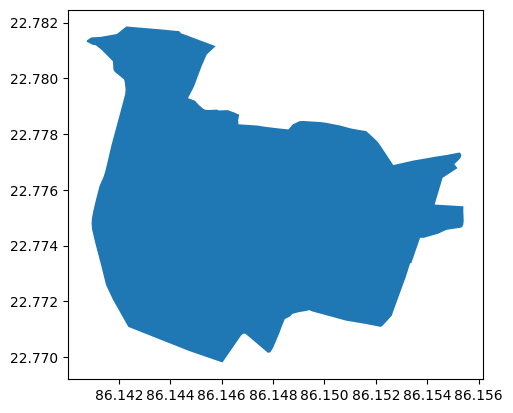

In [53]:
import osmnx as ox

# Try to get NIT Jamshedpur
nit_gdf = ox.geocode_to_gdf("NIT Jamshedpur, Jharkhand, India")
nit_gdf.to_file("nit_jsr.geojson", driver="GeoJSON")
# Load again with geopandas
campus_boundary = gpd.read_file("nit_jsr.geojson")

print(campus_boundary.crs)
campus_boundary.plot()

## Download NDVI and LST layers for Jamshedpur

In [54]:
task_lst = ee.batch.Export.image.toDrive(image=final_lst,
                                         description='LST_Jamshedpur',
                                         folder='GEE_Exports',
                                         scale=30, # Resolution in meters
                                         region=aoi)
task_lst.start()

task_ndvi = ee.batch.Export.image.toDrive(image=final_ndvi,
                                          description='NDVI_Jamshedpur',
                                          folder='GEE_Exports',
                                          scale=30,
                                          region=aoi)
task_ndvi.start()

print("Export tasks started. Check your Google Drive in a few minutes.")

Export tasks started. Check your Google Drive in a few minutes.


In [55]:
import ee
import geopandas as gpd

ee.Authenticate()
ee.Initialize(project="gee-jsr")

# --- 1. Convert your GeoJSON to GEE geometry ---
city_boundary = gpd.read_file('nit_jsr.geojson')
aoi_geometry = city_boundary.geometry.iloc[0].__geo_interface__
aoi = ee.Geometry.Polygon(aoi_geometry['coordinates'])

# --- 2. Filter the Landsat Image Collection ---
collection = ee.ImageCollection('LANDSAT/LC09/C02/T1_L2') \
    .filterBounds(aoi) \
    .filterDate('2025-04-01', '2025-06-30') \
    .filter(ee.Filter.lt('CLOUD_COVER', 10))

# --- 3. Median composite ---
image = collection.median()

# --- 4. NDVI ---
nir = image.select('SR_B5')
red = image.select('SR_B4')
ndvi = nir.subtract(red).divide(nir.add(red)).rename('NDVI')

# --- 5. Land Surface Temperature (LST) ---
thermal_band = image.select('ST_B10')
lst = thermal_band.multiply(0.00341802).add(149.0).subtract(273.15).rename('LST')

# --- 6. Clip to AOI ---
final_ndvi = ndvi.clip(aoi)
final_lst = lst.clip(aoi)

print("GEE processing complete! Ready to export or visualize.")


GEE processing complete! Ready to export or visualize.


In [56]:
import folium
from geemap import foliumap

# --- 7. Visualization parameters ---
ndvi_vis = {'min': 0, 'max': 1, 'palette': ['white', 'green']}
lst_vis = {'min': 20, 'max': 45, 'palette': ['blue', 'yellow', 'red']}

# --- 8. Center the map on your AOI ---
city_boundary = city_boundary.to_crs(epsg=4326)  # reproject to lat/lon
map_center = [city_boundary.centroid.y.iloc[0], city_boundary.centroid.x.iloc[0]]

m = folium.Map(location=map_center, zoom_start=10)

# --- 9. Convert NDVI and LST to map layers ---
ndvi_map_id = ee.Image(final_ndvi).getMapId(ndvi_vis)
lst_map_id = ee.Image(final_lst).getMapId(lst_vis)

folium.TileLayer(
    tiles=ndvi_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='NDVI'
).add_to(m)

folium.TileLayer(
    tiles=lst_map_id['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='LST'
).add_to(m)

# --- 10. Add boundary layer ---
folium.GeoJson(
    city_boundary.to_json(),
    name="NIT Jamshedpur Boundary",
    style_function=lambda x: {"color": "black", "weight": 2, "fill": False},
).add_to(m)

folium.LayerControl().add_to(m)

m


/tmp/ipython-input-1199826939.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  map_center = [city_boundary.centroid.y.iloc[0], city_boundary.centroid.x.iloc[0]]


## Ward Boundaries of Jamshedpur


*   Webscraping of arcgis website to fetch ward data




In [68]:
import requests
import json

base_url = "https://services6.arcgis.com/VuQUip1UjzxgxRB3/arcgis/rest/services/Thana_Ward_Boundary/FeatureServer/1/query"



*   Define the correct parameters




In [72]:
#We are telling the server to give us everything in the right format.
params = {
    "where": "1=1",         #get all features
    "outFields": "*",       #get all data columns (like Ward No.)
    "outSR": "4326",        #The standard lat/lon map projection
    "f": "geojson"          #The format that geopandas needs to process i.e. geojson
}



*   Make the request and load the data



In [73]:
print("Requesting ward boundary data from the server...")
#Make the web request
response = requests.get(base_url, params=params)
#Load the GeoJSON data from the response text
data = response.json()

Requesting ward boundary data from the server...




*   Convert the raw GeoJSON into a GeoDataFrame


In [74]:
# Convert the raw GeoJSON into a GeoDataFrame
wards = gpd.GeoDataFrame.from_features(data["features"])

print(f"Success! Loaded {len(wards)} wards.")
print("Here's a preview of the data:")
print(wards.head())

Success! Loaded 16 wards.
Here's a preview of the data:
                                            geometry    Ward_Name Ward_No  \
0  POLYGON ((86.25578 22.75778, 86.25569 22.75779...  Ward No. 18      18   
1  POLYGON ((86.18256 22.82504, 86.18237 22.82471...  Ward No. 01      01   
2  POLYGON ((86.17385 22.81555, 86.17386 22.81551...  Ward No. 02      02   
3  POLYGON ((86.18394 22.81053, 86.18392 22.81037...  Ward No. 03      03   
4  POLYGON ((86.18393 22.79875, 86.18401 22.79871...  Ward No. 04      04   

  Municipal_Name Remarks Zone_Name Location  Area_Hectare    Area_acre  \
0           None    None      None     None           501  1463.665315   
1           None    None      None     None           547  1598.961005   
2           None    None      None     None           398  1164.094962   
3           None    None      None     None           340   994.885426   
4           None    None      None     None           192   570.742431   

   No_Of_Sheets Population  OBJECTID



*   Visualisation




Displaying the map of ward boundaries...


<Axes: >

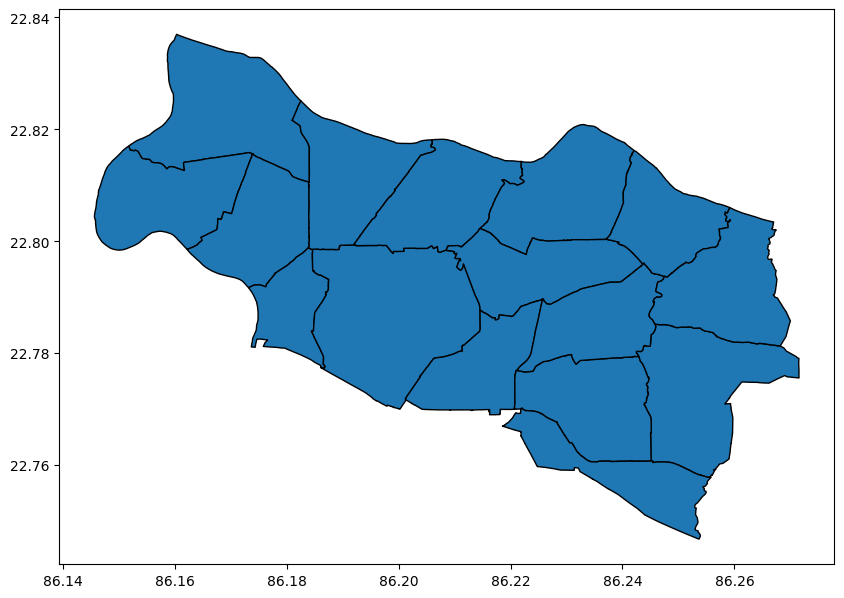

In [75]:
print("\nDisplaying the map of ward boundaries...")
wards.plot(figsize=(10, 10), edgecolor='black')

# Zonal Statistics

In [80]:
pip install rasterstats

In [81]:
from rasterstats import zonal_stats
import pandas as pd

#Calculating average temperature for each ward
temp_stats = zonal_stats(wards, 'LST_Jamshedpur.tif', stats="mean")
temp_df = pd.DataFrame(temp_stats)
wards['avg_temp'] = temp_df['mean']

#Calculate average NDVI for each ward
ndvi_stats = zonal_stats(wards, 'NDVI_Jamshedpur.tif', stats="mean")
ndvi_df = pd.DataFrame(ndvi_stats)
wards['avg_ndvi'] = ndvi_df['mean']

# Display the result. You now have a GeoDataFrame with analytics!
print(wards.head())

                                            geometry    Ward_Name Ward_No  \
0  POLYGON ((86.25578 22.75778, 86.25569 22.75779...  Ward No. 18      18   
1  POLYGON ((86.18256 22.82504, 86.18237 22.82471...  Ward No. 01      01   
2  POLYGON ((86.17385 22.81555, 86.17386 22.81551...  Ward No. 02      02   
3  POLYGON ((86.18394 22.81053, 86.18392 22.81037...  Ward No. 03      03   
4  POLYGON ((86.18393 22.79875, 86.18401 22.79871...  Ward No. 04      04   

  Municipal_Name Remarks Zone_Name Location  Area_Hectare    Area_acre  \
0           None    None      None     None           501  1463.665315   
1           None    None      None     None           547  1598.961005   
2           None    None      None     None           398  1164.094962   
3           None    None      None     None           340   994.885426   
4           None    None      None     None           192   570.742431   

   No_Of_Sheets  Population  OBJECTID   Shape__Area  Shape__Length  \
0             9       

## Data Cleaning on the 'wards' dataframe

*   Convert the key columns to a numeric type, just in case they were loaded as text.
*   The 'coerce' option will turn any non-numeric values into blanks (NaN).



In [82]:
wards['Population'] = pd.to_numeric(wards['Population'], errors='coerce')
wards['Area_Hectare'] = pd.to_numeric(wards['Area_Hectare'], errors='coerce')



*   Drop any rows that might have become blank during conversion



In [83]:
wards.dropna(subset=['Population', 'Area_Hectare'], inplace=True)
print("Data types cleaned and verified.")

Data types cleaned and verified.


### Calculate Population Density

In [85]:
wards['area_sq_km'] = wards['Area_Hectare'] * 0.01
wards['pop_density'] = (wards['Population'] / wards['area_sq_km']).round(2)

print(wards[['Ward_No', 'Population', 'area_sq_km', 'pop_density']].head())

  Ward_No  Population  area_sq_km  pop_density
0      18       28944        5.01      5777.25
1      01       52835        5.47      9659.05
2      02       31763        3.98      7980.65
3      03       30816        3.40      9063.53
4      04       18555        1.92      9664.06


### Creating the "Heat Risk Score"



All the metrics are on different scales

*   Temperature (avg_temp) might range from 35°C to 45°C.
*   Vegetation (avg_ndvi) ranges from 0.1 to 0.4.

*   Population Density (pop_density) could be from 5,000 to 25,000 people/km².






In [89]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

#This converts each column to a 0-1 scale.
#The coolest ward gets a 'temp_norm' of 0, the hottest gets 1.
wards['temp_norm'] = scaler.fit_transform(wards[['avg_temp']])
#The least green ward gets an 'ndvi_norm' of 0, the greenest gets 1.
wards['ndvi_norm'] = scaler.fit_transform(wards[['avg_ndvi']])
#The least dense ward gets a 'pop_density_norm' of 0, the densest gets 1.
wards['pop_density_norm'] = scaler.fit_transform(wards[['pop_density']])



*   Weighted score



In [90]:
#50% of the risk comes from high temperature ,20% from a LACK of greenery ,30% from high population density
wards['heat_risk_score'] = (
    0.5 * wards['temp_norm'] +
    0.2 * (1 - wards['ndvi_norm']) +
    0.3 * wards['pop_density_norm']
)

print("Top 5 most at-risk wards:")
print(wards[['Ward_Name', 'heat_risk_score']].sort_values(by='heat_risk_score', ascending=False).head())

Top 5 most at-risk wards:
      Ward_Name  heat_risk_score
5   Ward No. 05         0.700000
10  Ward No. 13         0.679776
4   Ward No. 04         0.521117
15  Ward No. 19         0.474190
1   Ward No. 01         0.467783


## Build the Final Interactive Map

In [61]:
map_center = [wards.dissolve().centroid.y, wards.dissolve().centroid.x]
#'CartoDB positron' is a clean, black-and-white base map style that lets data stand out.
my_map = folium.Map(location=map_center, zoom_start=12, tiles="CartoDB positron")

choropleth = folium.Choropleth(
    geo_data=wards.to_json(),
    data=wards,
    #Specifies which columns to use: 'Ward_No' to identify the ward and 'heat_risk_score' to determine its color.
    columns=['Ward_No', 'heat_risk_score'],
    key_on='feature.properties.Ward_No',
    #Sets the color scheme. 'YlOrRd' is a classic heat map palette from Yellow to Orange to Red.
    fill_color='YlOrRd',
    fill_opacity=0.8,
    line_opacity=0.3,
    legend_name='Heat Risk Score (Higher is Worse)'
).add_to(my_map)

folium.GeoJsonTooltip(
    fields=['Ward_Name', 'avg_temp', 'avg_ndvi', 'Population', 'pop_density', 'heat_risk_score'],
    #User-friendly labels for each of the fields in the tooltip.
    aliases=['Ward:', 'Avg Temp (°C):', 'Avg Vegetation:', 'Population (2011):', 'People/km²:', 'Heat Risk Score:'],
    style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;")
).add_to(choropleth.geojson)

folium.LayerControl().add_to(my_map)

map_filename = "Jamshedpur_Heat_Risk_Map.html"
my_map.save(map_filename)


--- Step 3: Building the final interactive map ---


/usr/local/lib/python3.12/dist-packages/folium/utilities.py:103: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/usr/local/lib/python3.12/dist-packages/folium/utilities.py:109: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/usr/local/lib/python3.12/dist-packages/folium/utilities.py:111: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]
